SpaceX Falcon 9 Landing Prediction: Machine Learning Pipeline
In this notebook, we will build and evaluate several machine learning models to predict if the Falcon 9 first stage will land successfully. We will perform data preparation, hyperparameter tuning using GridSearchCV, and compare the final models based on their performance on a held-out test set.
Initial Setup: Import Libraries and Load Data
Explanation:
First, we import all the necessary libraries for data manipulation, preprocessing, model creation, and evaluation. We then load our two datasets: dataset_part_2.csv which contains the Class column (our target), and dataset_part_3.csv which contains the preprocessed, one-hot encoded features (X).

In [1]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- Load Data ---
# Direct download of CSV files using pandas for standard Jupyter
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
URL2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"

# Load the data
data = pd.read_csv(URL1)
X = pd.read_csv(URL2)

# Display the first few rows to confirm data is loaded
print("\nData with Target Class (data):")
print(data.head())

print("\nFeature Data (X):")
print(X.head(100))



Data with Target Class (data):
   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  Class  
0            0  B0

In [2]:
# Add these imports to your first cell
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

TASK 1: Create Target Variable Y
Explanation:
Machine learning models in scikit-learn require the target variable (the value we want to predict) to be in a separate, one-dimensional array. Here, we select the Class column from our data DataFrame and convert it into a NumPy array, which we will call Y.

In [3]:
# Create a NumPy array from the 'Class' column and assign it to Y
Y = data['Class'].to_numpy()

# Display the first 10 elements of Y to verify
print(Y[:10])

[0 0 0 0 0 0 1 1 0 0]


TASK 2: Standardize Feature Data X
Explanation:
Standardization is a crucial preprocessing step that scales our feature data to have a mean of 0 and a standard deviation of 1. This prevents features with large numerical ranges (like PayloadMass) from dominating the model's learning process. We use preprocessing.StandardScaler to learn the scaling parameters from our data and apply the transformation.

In [4]:
# Standardize the data in X using the StandardScaler
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

# The output X is now a NumPy array with scaled values
print(X[0:1]) # Display the first row to see the scaled data

[[-1.71291154e+00 -1.94814463e-16 -6.53912840e-01 -1.57589457e+00
  -9.73440458e-01 -1.05999788e-01 -1.05999788e-01 -6.54653671e-01
  -1.05999788e-01 -5.51677284e-01  3.44342023e+00 -1.85695338e-01
  -3.33333333e-01 -1.05999788e-01 -2.42535625e-01 -4.29197538e-01
   7.97724035e-01 -5.68796459e-01 -4.10890702e-01 -4.10890702e-01
  -1.50755672e-01 -7.97724035e-01 -1.50755672e-01 -3.92232270e-01
   9.43398113e+00 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.50755672e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.50755672e-01 -1.05999788e-01 -1.50755672e-01
  -1.50755672e-01 -1.05999788e-01 -1.50755672e-01 -1.50755672e-01
  -1.05999788e-01 -1.05999788e-01 -1.50755672e-01 -1.50755672e-01
  -1.50755

TASK 3: Split Data into Training and Testing Sets
Explanation:
We split our dataset into two parts: a training set (which we'll use to train our models and tune their hyperparameters) and a test set (which will be held back as completely unseen data to evaluate final model performance). We use an 80/20 split and set random_state=2 to ensure our results are reproducible.

In [5]:
# Use train_test_split to create training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Print the shapes of the new datasets to confirm the split
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (72, 83) (72,)
Test set: (18, 83) (18,)


TASK 4 & 5: Logistic Regression
Explanation:
We will first create a Logistic Regression model. We'll use GridSearchCV to systematically test different hyperparameters (C, penalty, solver) using 10-fold cross-validation to find the combination that performs best on the training data. After finding the best model, we will calculate its accuracy on the unseen test data.

In [6]:
# TASK 4: Create and tune the Logistic Regression model
parameters_lr = {'C':[0.01,0.1,1],
                 'penalty':['l2'],
                 'solver':['lbfgs']}

lr = LogisticRegression(random_state=1)
logreg_cv = GridSearchCV(lr, parameters_lr, cv=10)
logreg_cv.fit(X_train, Y_train)

print("Tuned Logistic Regression Parameters: ", logreg_cv.best_params_)
print("Best CV Accuracy (Logistic Regression):", logreg_cv.best_score_)

# TASK 5: Calculate the accuracy on the test data
test_accuracy_lr = logreg_cv.score(X_test, Y_test)
print("Test Accuracy (Logistic Regression):", test_accuracy_lr)

Tuned Logistic Regression Parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Accuracy (Logistic Regression): 0.8464285714285713
Test Accuracy (Logistic Regression): 0.8333333333333334


Confusion Matrix for Logistic Regression:


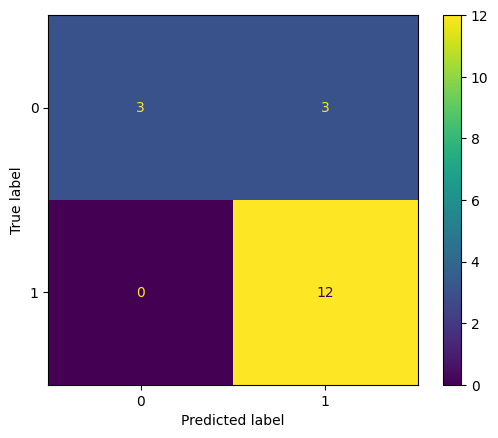

In [7]:
# --- Plotting the Confusion Matrix for Logistic Regression ---

# 1. Get the predictions from your fitted model (you already have this line)
yhat_lr = logreg_cv.predict(X_test)

# 2. Calculate the confusion matrix values
cm_lr = confusion_matrix(Y_test, yhat_lr)

# 3. Create a display object
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)

# 4. Plot the matrix
print("Confusion Matrix for Logistic Regression:")
disp_lr.plot()
plt.show()

TASK 6 & 7: Support Vector Machine (SVM)
Explanation:
Next, we create and tune a Support Vector Machine (SVM) model. We will test different kernels, C values (regularization strength), and gamma values to find the optimal combination for our data.

In [8]:
# TASK 6: Create and tune the SVM model
parameters_svm = {'kernel':('linear', 'rbf','poly','sigmoid'),
                  'C': np.logspace(-3, 3, 5),
                  'gamma':np.logspace(-3, 3, 5)}

svm = SVC(random_state=1)
svm_cv = GridSearchCV(svm, parameters_svm, cv=10)
svm_cv.fit(X_train, Y_train)

print("Tuned SVM Parameters: ", svm_cv.best_params_)
print("Best CV Accuracy (SVM):", svm_cv.best_score_)

# TASK 7: Calculate the accuracy on the test data
test_accuracy_svm = svm_cv.score(X_test, Y_test)
print("Test Accuracy (SVM):", test_accuracy_svm)

Tuned SVM Parameters:  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Best CV Accuracy (SVM): 0.8482142857142856
Test Accuracy (SVM): 0.8333333333333334



Confusion Matrix for Support Vector Machine (SVM):


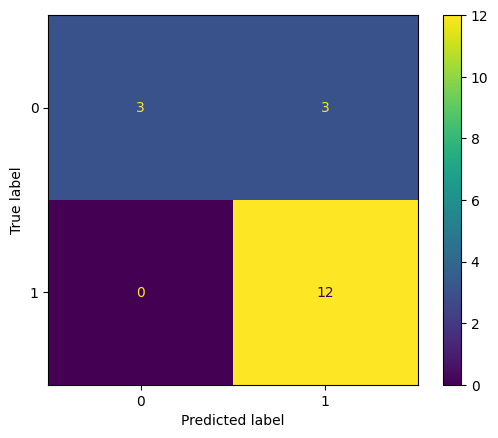

In [9]:
# --- Plotting the Confusion Matrix for SVM ---

yhat_svm = svm_cv.predict(X_test)
cm_svm = confusion_matrix(Y_test, yhat_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)

print("\nConfusion Matrix for Support Vector Machine (SVM):")
disp_svm.plot()
plt.show()

TASK 8 & 9: Decision Tree
Explanation:
Here, we build a Decision Tree classifier. We tune a wide range of parameters that control the tree's structure, such as the splitting criterion (gini, entropy), maximum depth, and the minimum number of samples required to split a node or form a leaf.

In [10]:
# TASK 8: Create and tune the Decision Tree model
# CORRECTED Code
parameters_tree = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random'],
                   'max_depth': [2*n for n in range(1,10)],
                   'max_features': ['sqrt'], # <--- 'auto' has been removed
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier(random_state=1)
tree_cv = GridSearchCV(tree, parameters_tree, cv=10)
tree_cv.fit(X_train, Y_train)

print("Tuned Decision Tree Parameters: ", tree_cv.best_params_)
print("Best CV Accuracy (Decision Tree):", tree_cv.best_score_)

# TASK 9: Calculate the accuracy on the test data
test_accuracy_tree = tree_cv.score(X_test, Y_test)
print("Test Accuracy (Decision Tree):", test_accuracy_tree)

Tuned Decision Tree Parameters:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
Best CV Accuracy (Decision Tree): 0.8357142857142857
Test Accuracy (Decision Tree): 0.7777777777777778


TASK 10 & 11: K-Nearest Neighbors (KNN)
Explanation:
Finally, we create a K-Nearest Neighbors (KNN) model. The main hyperparameter here is n_neighbors, which determines how many neighbors are considered when classifying a new data point. We'll test values from 1 to 10.

In [11]:
# TASK 10: Create and tune the KNN model
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'p': [1,2]}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters_knn, cv=10)
knn_cv.fit(X_train, Y_train)

print("Tuned KNN Parameters: ", knn_cv.best_params_)
print("Best CV Accuracy (KNN):", knn_cv.best_score_)

# TASK 11: Calculate the accuracy on the test data
test_accuracy_knn = knn_cv.score(X_test, Y_test)
print("Test Accuracy (KNN):", test_accuracy_knn)

Tuned KNN Parameters:  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Best CV Accuracy (KNN): 0.8482142857142858
Test Accuracy (KNN): 0.8333333333333334



Confusion Matrix for K-Nearest Neighbors (KNN):


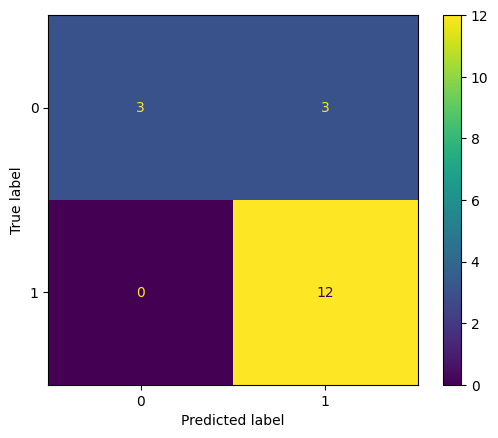

In [12]:
# --- Plotting the Confusion Matrix for K-Nearest Neighbors (KNN) ---

yhat_knn = knn_cv.predict(X_test)
cm_knn = confusion_matrix(Y_test, yhat_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)

print("\nConfusion Matrix for K-Nearest Neighbors (KNN):")
disp_knn.plot()
plt.show()

TASK 12: Find the Method That Performs Best
Explanation:
To determine the best overall model, we must compare their performance on the unseen test data. The accuracy on the validation set (the best_score_ from GridSearchCV) is used for tuning, but the test accuracy is the true measure of how well the model generalizes. We will create a simple report to compare the test accuracies.

In [13]:
# Create a dictionary to hold the test accuracies
model_performance = {
    'Logistic Regression': test_accuracy_lr,
    'Support Vector Machine': test_accuracy_svm,
    'Decision Tree': test_accuracy_tree,
    'K-Nearest Neighbors': test_accuracy_knn
}

# Find the best model
best_model_name = max(model_performance, key=model_performance.get)
best_model_accuracy = model_performance[best_model_name]

# Print a summary report
print("\n--- Model Performance Comparison ---")
for model, acc in model_performance.items():
    print(f"{model}: {acc:.4f}")
print("------------------------------------")
print(f"\nThe best performing model is '{best_model_name}' with a test accuracy of {best_model_accuracy:.4f}.")


--- Model Performance Comparison ---
Logistic Regression: 0.8333
Support Vector Machine: 0.8333
Decision Tree: 0.7778
K-Nearest Neighbors: 0.8333
------------------------------------

The best performing model is 'Logistic Regression' with a test accuracy of 0.8333.


C:\Users\Afribi\AppData\Local\Temp\ipykernel_15796\57206251.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=performance_df, palette='viridis')


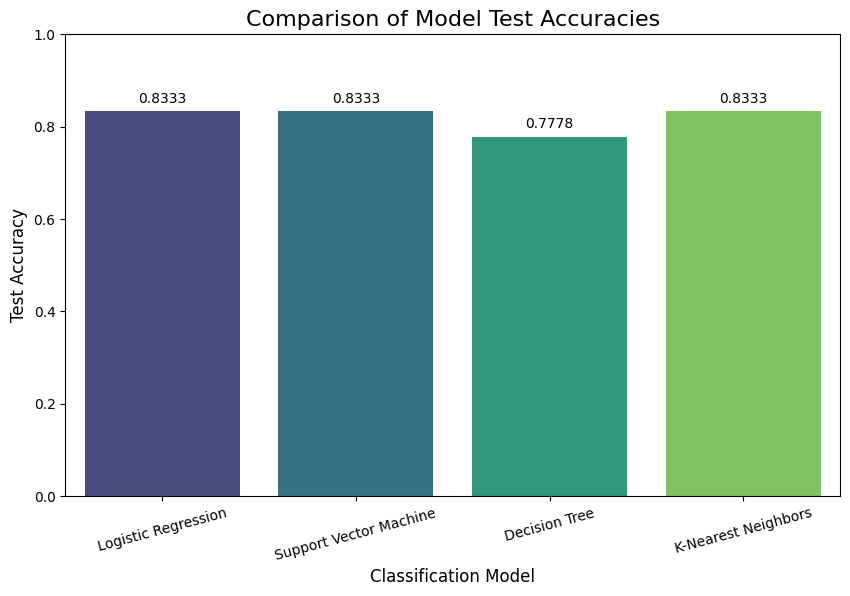

In [14]:
# Import the necessary visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pandas DataFrame from the model_performance dictionary
performance_df = pd.DataFrame(list(model_performance.items()), columns=['Model', 'Accuracy'])

# --- Plotting the Bar Chart ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=performance_df, palette='viridis')

# Set the title and labels for clarity
plt.title('Comparison of Model Test Accuracies', fontsize=16)
plt.xlabel('Classification Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1.0) # Set y-axis to be from 0 to 1 for percentage context

# Add the accuracy values on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Rotate x-axis labels for better readability if they overlap
plt.xticks(rotation=15)

# Show the plot
plt.show()